# Prepare Environment

In [83]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.display import display

import os
import re
import string
import pandas as pd
import numpy as np
import tracemalloc
import time

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
%matplotlib inline

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
print(tf.__version__)

2.4.0


In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
get_available_gpus()

[]

## Init Dataset

In [6]:
working_dir = './Original_Dataset'
img_dir = dict()

In [7]:
meta_dir = os.path.join(working_dir, 'Meta')

img_dir['android'] = os.path.join(working_dir, 'IMG_Android')
img_dir['digital_camera'] = os.path.join(working_dir, 'IMG_Digital')
img_dir['ios'] = os.path.join(working_dir, 'IMG_iPhone')

# Select the existing model

In [8]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
BaseModel = tf.keras.applications.EfficientNetB7
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# BaseModel = tf.keras.applications.mobilenet_v2.MobileNetV2

# Load Dataset

In [9]:
# Digital
dgt_df = pd.read_excel(os.path.join(meta_dir, 'coffee_bean_Digital.xlsx'), engine='openpyxl')
dgt_df['Source'] = 'digital_camera'
# display(dgt_df.head(20))

# Android
and_df = pd.read_excel(os.path.join(meta_dir, 'coffee_bean_Android.xlsx'), engine='openpyxl')
and_df['Source'] = 'android'
# display(and_df.head(20))

# iPhone
ios_df = pd.read_excel(os.path.join(meta_dir, 'coffee_bean_iPhone.xlsx'), engine='openpyxl')
ios_df['Source'] = 'ios'
# display(ios_df.head(20))

data_df = pd.concat([dgt_df, and_df, ios_df], axis=0)
data_df = data_df.iloc[:, :14].dropna(subset=['pH'])
display(data_df.shape)
display(data_df.head(20))

(360, 14)

,Name,Red,Green,Blue,Gray,Contrast,Energy,Homogeneity,Asm,Correlation,Dissimilarity,Group,pH,Source
0,BAL1,19.17,13.49,8.50,14.62,67.28,0.73,0.77,0.53,0.96,2.74,1.0,4.86,digital_camera
1,BAL2,17.23,12.19,7.54,13.16,61.78,0.73,0.77,0.53,0.95,2.52,1.0,4.86,digital_camera
2,BAL3,17.39,12.53,8.08,13.47,72.57,0.73,0.77,0.53,0.95,2.66,1.0,4.86,digital_camera
3,BAL4,16.62,11.73,7.32,12.69,62.59,0.75,0.78,0.56,0.95,2.46,1.0,4.86,digital_camera
4,BAL5,14.97,10.67,6.66,11.50,61.59,0.74,0.79,0.55,0.94,2.30,1.0,4.86,digital_camera
5,BAL6,14.46,10.35,6.46,11.14,48.81,0.75,0.79,0.56,0.95,2.07,1.0,4.86,digital_camera
6,BAL7,15.57,11.12,6.95,11.98,57.56,0.74,0.78,0.54,0.95,2.32,1.0,4.86,digital_camera
7,BAL8,16.79,12.02,7.65,12.95,58.35,0.73,0.78,0.54,0.96,2.40,1.0,4.86,digital_camera
8,BAL9,17.91,12.76,8.18,13.78,70.52,0.73,0.77,0.53,0.95,2.70,1.0,4.86,digital_camera
9,BAL10,16.14,11.60,7.46,12.49,64.02,0.74,0.78,0.55,0.95,2.42,1.0,4.86,digital_camera


In [10]:
def extract_bean(row):
    return re.compile("[0-9]+").split(row['Name'])[0]

data_df['Bean'] = data_df.apply(extract_bean, axis=1)
display(data_df)

,Name,Red,Green,Blue,Gray,Contrast,Energy,Homogeneity,Asm,Correlation,Dissimilarity,Group,pH,Source,Bean
0,BAL1,19.17,13.49,8.50,14.62,67.28,0.73,0.77,0.53,0.96,2.74,1.0,4.86,digital_camera,BAL
1,BAL2,17.23,12.19,7.54,13.16,61.78,0.73,0.77,0.53,0.95,2.52,1.0,4.86,digital_camera,BAL
2,BAL3,17.39,12.53,8.08,13.47,72.57,0.73,0.77,0.53,0.95,2.66,1.0,4.86,digital_camera,BAL
3,BAL4,16.62,11.73,7.32,12.69,62.59,0.75,0.78,0.56,0.95,2.46,1.0,4.86,digital_camera,BAL
4,BAL5,14.97,10.67,6.66,11.50,61.59,0.74,0.79,0.55,0.94,2.30,1.0,4.86,digital_camera,BAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,CD6,19.60,16.13,14.09,16.93,187.53,0.66,0.68,0.43,0.88,5.94,4.0,5.43,ios,CD
116,CD7,10.34,8.11,6.52,8.59,95.70,0.69,0.72,0.48,0.81,4.10,4.0,5.43,ios,CD
117,CD8,11.42,8.95,7.02,9.47,93.11,0.67,0.69,0.44,0.83,4.32,4.0,5.43,ios,CD
118,CD9,10.79,8.41,6.69,8.93,87.49,0.66,0.70,0.44,0.82,4.10,4.0,5.43,ios,CD


In [11]:
display(data_df.groupby('Bean')['pH'].unique())
display(np.sort(data_df['pH'].unique()))

Bean
BAD    [5.78]
BAL    [4.86]
BAM    [5.33]
BPD    [5.33]
BPL    [4.88]
BPM    [5.32]
CD     [5.43]
CM     [5.16]
PD     [5.83]
PM     [5.09]
WL     [5.16]
WM     [5.26]
Name: pH, dtype: object

array([4.86, 4.88, 5.09, 5.16, 5.26, 5.32, 5.33, 5.43, 5.78, 5.83])

In [12]:
def real2class(row):
    if row['pH'] <= 5.0:
        return 0
    elif row['pH'] <= 5.2:
        return 1
    elif row['pH'] <= 5.5:
        return 2
    else:
        return 3

class_names = ['<=5.0', '(5.0,5.2]', '(5.2,5.5]', '>5.5']
num_classes = len(class_names)

data_df['class'] = data_df.apply(real2class, axis=1)
display(data_df)
display(data_df['class'].unique())

,Name,Red,Green,Blue,Gray,Contrast,Energy,Homogeneity,Asm,Correlation,Dissimilarity,Group,pH,Source,Bean,class
0,BAL1,19.17,13.49,8.50,14.62,67.28,0.73,0.77,0.53,0.96,2.74,1.0,4.86,digital_camera,BAL,0
1,BAL2,17.23,12.19,7.54,13.16,61.78,0.73,0.77,0.53,0.95,2.52,1.0,4.86,digital_camera,BAL,0
2,BAL3,17.39,12.53,8.08,13.47,72.57,0.73,0.77,0.53,0.95,2.66,1.0,4.86,digital_camera,BAL,0
3,BAL4,16.62,11.73,7.32,12.69,62.59,0.75,0.78,0.56,0.95,2.46,1.0,4.86,digital_camera,BAL,0
4,BAL5,14.97,10.67,6.66,11.50,61.59,0.74,0.79,0.55,0.94,2.30,1.0,4.86,digital_camera,BAL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,CD6,19.60,16.13,14.09,16.93,187.53,0.66,0.68,0.43,0.88,5.94,4.0,5.43,ios,CD,2
116,CD7,10.34,8.11,6.52,8.59,95.70,0.69,0.72,0.48,0.81,4.10,4.0,5.43,ios,CD,2
117,CD8,11.42,8.95,7.02,9.47,93.11,0.67,0.69,0.44,0.83,4.32,4.0,5.43,ios,CD,2
118,CD9,10.79,8.41,6.69,8.93,87.49,0.66,0.70,0.44,0.82,4.10,4.0,5.43,ios,CD,2


array([0, 1, 2, 3])

In [13]:
def set_path(data):
    return os.path.join(img_dir[data['Source']], re.sub(r'\d+', '', data['Name']), ".".join([data['Name'], 'jpg']))
    
img_fpaths = np.array(data_df.apply(set_path, axis=1))
# img_labels = data_df['pH'].values
img_labels = data_df[['class', 'Source']].values
print(img_fpaths, img_labels)

['./Original_Dataset/IMG_Digital/BAL/BAL1.jpg'
 './Original_Dataset/IMG_Digital/BAL/BAL2.jpg'
 './Original_Dataset/IMG_Digital/BAL/BAL3.jpg'
 './Original_Dataset/IMG_Digital/BAL/BAL4.jpg'
 './Original_Dataset/IMG_Digital/BAL/BAL5.jpg'
 './Original_Dataset/IMG_Digital/BAL/BAL6.jpg'
 './Original_Dataset/IMG_Digital/BAL/BAL7.jpg'
 './Original_Dataset/IMG_Digital/BAL/BAL8.jpg'
 './Original_Dataset/IMG_Digital/BAL/BAL9.jpg'
 './Original_Dataset/IMG_Digital/BAL/BAL10.jpg'
 './Original_Dataset/IMG_Digital/BPL/BPL1.jpg'
 './Original_Dataset/IMG_Digital/BPL/BPL2.jpg'
 './Original_Dataset/IMG_Digital/BPL/BPL3.jpg'
 './Original_Dataset/IMG_Digital/BPL/BPL4.jpg'
 './Original_Dataset/IMG_Digital/BPL/BPL5.jpg'
 './Original_Dataset/IMG_Digital/BPL/BPL6.jpg'
 './Original_Dataset/IMG_Digital/BPL/BPL7.jpg'
 './Original_Dataset/IMG_Digital/BPL/BPL8.jpg'
 './Original_Dataset/IMG_Digital/BPL/BPL9.jpg'
 './Original_Dataset/IMG_Digital/BPL/BPL10.jpg'
 './Original_Dataset/IMG_Digital/CM/CM1.jpg'
 './Original_

In [61]:
from sklearn.model_selection import train_test_split
from collections import Counter
# Different soruce
source = 'android'
img_train, img_test, label_train, label_test = train_test_split(
    img_fpaths[img_labels[:,1]==source], img_labels[img_labels[:,1]==source], 
    random_state=42,
    stratify=img_labels[img_labels[:,1]==source][:,0],  # stratified
    test_size=0.5)

label_test = label_test[:,0]
label_train = label_train[:,0]

img_valid, img_test, label_valid, label_test = train_test_split(
    img_test, label_test, 
    random_state=42,
    stratify=label_test,  # stratified
    test_size=0.5)

img_train = np.concatenate((img_train, img_fpaths[img_labels[:,1]!=source]), axis=0)
label_train = np.concatenate((label_train, img_labels[img_labels[:,1]!=source][:,0]), axis=0)

label_train = label_train.astype(int)
label_valid = label_valid.astype(int)
label_test = label_test.astype(int)

print(f'Training set: {img_train.shape} {label_train.shape}')
print(f'{Counter(label_train)}')
print(f'Validation set: {img_valid.shape} {label_valid.shape}')
print(f'{Counter(label_valid)}')
print(f'Test set: {img_test.shape} {label_test.shape}')
print(f'{Counter(label_test)}')

Training set: (300,) (300,)
Counter({2: 125, 1: 75, 0: 50, 3: 50})
Validation set: (30,) (30,)
Counter({2: 13, 1: 7, 0: 5, 3: 5})
Test set: (30,) (30,)
Counter({2: 12, 1: 8, 0: 5, 3: 5})


In [26]:
from sklearn.model_selection import train_test_split
from collections import Counter
# Combined source
img_train, img_test, label_train, label_test = train_test_split(
    img_fpaths, img_labels[,:0], 
    random_state=42,
    stratify=img_labels,  # stratified
    test_size=0.2)

img_valid, img_test, label_valid, label_test = train_test_split(
    img_test, label_test, 
    random_state=42,
    stratify=label_test,  # stratified
    test_size=0.5)

label_train = label_train.astype(int)
label_valid = label_valid.astype(int)
label_test = label_test.astype(int)

print(f'Training set: {img_train.shape} {label_train.shape}')
print(f'{Counter(label_train)}')
print(f'Validation set: {img_valid.shape} {label_valid.shape}')
print(f'{Counter(label_valid)}')
print(f'Test set: {img_test.shape} {label_test.shape}')
print(f'{Counter(label_test)}')

Training set: (288,) (288,)
Counter({2: 120, 1: 72, 3: 48, 0: 48})
Validation set: (36,) (36,)
Counter({2: 15, 1: 9, 3: 6, 0: 6})
Test set: (36,) (36,)
Counter({2: 15, 1: 9, 0: 6, 3: 6})


# Tensorflow Dataset with Data Augmentation

In [15]:
# Target image size that we will feed into the model.
IMG_SIZE = (224, 224)

# Batch size
batch_size = 16

In [16]:
def resize_and_preprocess(file_path, label):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    # feature scaling
    img = preprocess_input(img)
    return img, label

In [17]:
def data_augment(file_path, label):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.9, 1.0)
    # feature scaling
    img = preprocess_input(img)
    return img, label

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(100)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(resize_and_preprocess, num_parallel_calls=AUTOTUNE)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [44]:
# Training set
train_ds = tf.data.Dataset.from_tensor_slices((img_train, label_train))
train_ds = prepare(train_ds, shuffle=True, augment=True)

# Validation set
valid_ds = tf.data.Dataset.from_tensor_slices((img_valid, label_valid))
valid_ds = prepare(valid_ds)

# Test set
test_ds = tf.data.Dataset.from_tensor_slices((img_test, label_test))
test_ds = prepare(test_ds)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

For visualization purpose, we will define the function that rescales the feature to be between 0 and 1, instead of using the `preprocess_input` function.

In [19]:
def resize_and_rescale(file_path, label):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    # feature scaling
    img = (img / 255.)
    return img, label

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Training


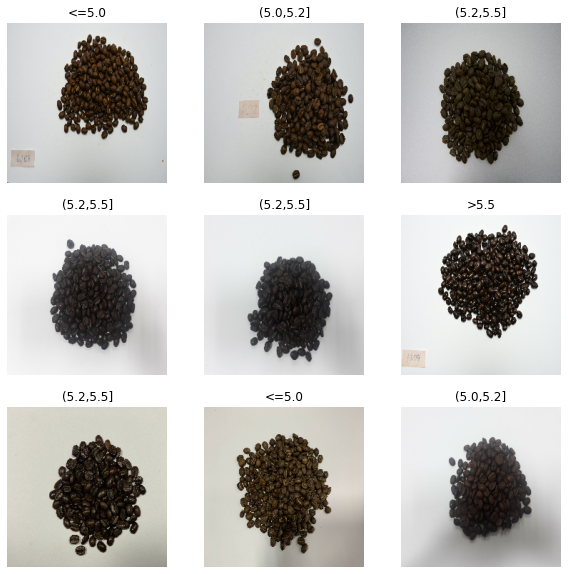

Validation


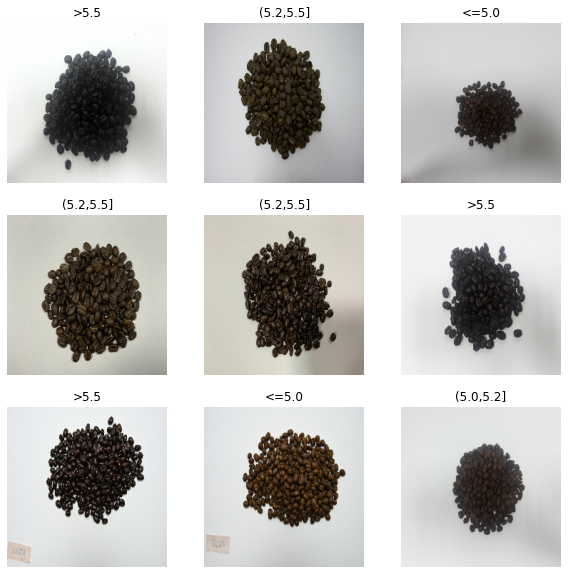

Test


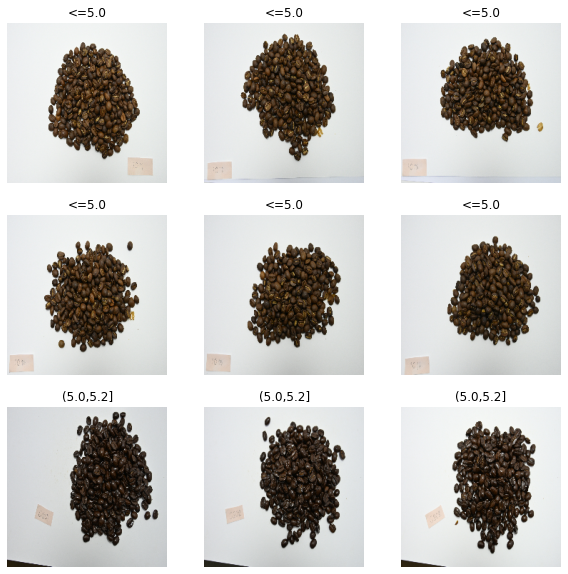

In [20]:
train_ds_viz = (
    tf.data.Dataset.from_tensor_slices((img_train, label_train))
    .map(resize_and_rescale)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
valid_ds_viz = (
    tf.data.Dataset.from_tensor_slices((img_valid, label_valid))
    .map(resize_and_rescale)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
test_ds_viz = (
    tf.data.Dataset.from_tensor_slices((img_test, label_test))
    .map(resize_and_rescale)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

def display_images(tfds):
    plt.figure(figsize=(10, 10))
    for bi, batch in enumerate(tfds.take(1)):
        b_img, b_label = batch
        # Convert from tensor to numpy
        b_img, b_label = b_img.numpy(), b_label.numpy()
        for i, (img, label) in enumerate(zip(b_img[:9], b_label[:9])):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(class_names[label])
            plt.axis("off")
    plt.show()
    plt.close('all')

print('Training')
display_images(train_ds_viz)
print('Validation')
display_images(valid_ds_viz)
print('Test')
display_images(test_ds_viz)

# Transfer Learning

In [24]:
base_model = BaseModel(
    input_shape=IMG_SIZE + (3,),  # plus (3, ) for the color channel
    weights='imagenet',
    include_top=False)

In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [26]:
model = tf.keras.models.Sequential()

model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes))

Here we print the list of newly added layers in the model.

In [27]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 mobilenetv2_1.00_224
1 global_average_pooling2d
2 dropout
3 dense
4 dropout_1
5 dense_1


In [28]:
for tmp_x, tmp_y in train_ds:
    break

## Training Only Top Layers

In [30]:
base_model.trainable = False

epochs = 30
batch_size = 16
learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy'])

hist = model.fit(
    train_ds,  # Here we use train_ds instead
    batch_size=batch_size,
    epochs=epochs,
    validation_data=valid_ds,  # Here we use valid_ds instead
    verbose=1)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/18 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.7089WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f67400b0440> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

In [32]:
# Predict the probability of each image
y_hat_valid_probs = model.predict(valid_ds)

# Select the class with the highest probability as the predicted class.
y_hat_valid = np.argmax(y_hat_valid_probs, axis=-1)

# Get label from the Dataset
y_valid = [label.numpy() for img, label in valid_ds]
y_valid = np.hstack(y_valid)

print(y_hat_valid_probs.shape)
print(y_hat_valid.shape)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(36, 4)
(36,)


In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.2f}')
print(f'Macro F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid, average="macro"):.2f}')

Validation Set
[[ 6  0  0  0]
 [ 2  3  4  0]
 [ 0  0 14  1]
 [ 0  0  2  4]]
Accuracy: 0.75
Macro F1-score: 0.72


## Fine-tuning Model

In [34]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [35]:
base_model.trainable = True
n_freezes = 135
for layer in base_model.layers[:n_freezes]:
    layer.trainable = False

epochs = 30
batch_size = 16
learning_rate = 0.0001

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy'])

hist = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=valid_ds,
    verbose=1)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/18 [==============================] - ETA: 0s - loss: 3.4601 - accuracy: 0.4061WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f66f4142680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

In [36]:
# Predict the probability of each image
y_hat_valid_probs = model.predict(valid_ds)

# Select the class with the highest probability as the predicted class.
y_hat_valid = np.argmax(y_hat_valid_probs, axis=-1)

# Get label from the Dataset
y_valid = [label.numpy() for img, label in valid_ds]
y_valid = np.hstack(y_valid)

print(y_hat_valid_probs.shape)
print(y_hat_valid.shape)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(36, 4)
(36,)


In [37]:
print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.2f}')
print(f'Macro F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid, average="macro"):.2f}')

Validation Set
[[ 6  0  0  0]
 [ 7  2  0  0]
 [11  4  0  0]
 [ 2  4  0  0]]
Accuracy: 0.22
Macro F1-score: 0.15


In [38]:
# Predict the probability of each image
y_hat_test_probs = model.predict(test_ds)

# Select the class with the highest probability as the predicted class.
y_hat_test = np.argmax(y_hat_test_probs, axis=-1)

# Get label from the Dataset
y_test = [label.numpy() for img, label in test_ds]
y_test = np.hstack(y_test)

print(y_hat_test_probs.shape)
print(y_hat_test.shape)

(36, 4)
(36,)


In [39]:
print('Test Set')
print(confusion_matrix(y_true=y_test, y_pred=y_hat_test))
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.2f}')
print(f'Macro F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test, average="macro"):.2f}')

Test Set
[[6 0 0 0]
 [4 5 0 0]
 [9 6 0 0]
 [5 1 0 0]]
Accuracy: 0.31
Macro F1-score: 0.22


# Cross-validation

In [122]:
# Combined source
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from collections import Counter

tracemalloc.start()
start_time = time.time()

fold = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'mcc': []}
source_all = []
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(img_fpaths, img_labels)

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
BaseModel = tf.keras.applications.EfficientNetB0
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# BaseModel = tf.keras.applications.MobileNetV2

all_y_hat_test = []
all_y_test = []
for f_idx, (train_index, test_index) in enumerate(skf.split(img_fpaths, img_labels[:,0].astype(int))):
    print(f'-= [Fold {f_idx}] =-')
    print('TRAIN:', train_index, 'TEST:', test_index)

    # Train and test
    img_train, img_test = img_fpaths[train_index], img_fpaths[test_index]
    label_train, label_test = img_labels[train_index][:,0].astype(int), img_labels[test_index][:,0].astype(int)
    source_all.append(img_labels[test_index][:,1])

    # Train and validation
    img_train, img_valid, label_train, label_valid = train_test_split(
        img_train, label_train, 
        random_state=42,
        stratify=label_train,  # stratified
        test_size=0.1)

    print(f'Training set: {img_train.shape} {label_train.shape}')
    print(f'{Counter(label_train)}')
    print(f'Validation set: {img_valid.shape} {label_valid.shape}')
    print(f'{Counter(label_valid)}')
    print(f'Test set: {img_test.shape} {label_test.shape}')
    print(f'{Counter(label_test)}')

    # Training set
    train_ds = tf.data.Dataset.from_tensor_slices((img_train, label_train))
    train_ds = prepare(train_ds, shuffle=True, augment=True)

    # Validation set
    valid_ds = tf.data.Dataset.from_tensor_slices((img_valid, label_valid))
    valid_ds = prepare(valid_ds)

    # Test set
    test_ds = tf.data.Dataset.from_tensor_slices((img_test, label_test))
    test_ds = prepare(test_ds)

    base_model = BaseModel(
        input_shape=IMG_SIZE + (3,),  # plus (3, ) for the color channel
        weights='imagenet',
        include_top=False)

    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes))
    

    if f_idx == 0:
        for i, layer in enumerate(base_model.layers):
            print(i, layer.name)

    # Train only top
    base_model.trainable = False
    epochs = 20
    batch_size = 16
    learning_rate = 0.0001
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy'])
    hist = model.fit(
        train_ds,  # Here we use train_ds instead
        batch_size=batch_size,
        epochs=epochs,
        validation_data=valid_ds,  # Here we use valid_ds instead
        verbose=1)

    # Fine-tuning
    base_model.trainable = True
    n_freezes = 795
    for layer in base_model.layers[:n_freezes]:
        layer.trainable = False
    epochs = 30
    batch_size = 16
    learning_rate = 0.0001
    mc = tf.keras.callbacks.ModelCheckpoint(
        f'best_model_{f_idx}.h5', monitor='val_accuracy',
        mode='max', verbose=1, 
        save_best_only=True)
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy'])
    hist = model.fit(
        train_ds,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=valid_ds,
        callbacks=[mc],
        verbose=1)
    best_model = tf.keras.models.load_model(f'best_model_{f_idx}.h5')
    model = best_model
    y_hat_valid_probs = model.predict(valid_ds)
    y_hat_valid = np.argmax(y_hat_valid_probs, axis=-1)
    y_valid = [label.numpy() for img, label in valid_ds]
    y_valid = np.hstack(y_valid)
    print('Validation Set')
    print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
    print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.2f}')
    print(f'Macro F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid, average="macro"):.2f}')
    y_hat_test_probs = model.predict(test_ds)
    y_hat_test = np.argmax(y_hat_test_probs, axis=-1)
    y_test = [label.numpy() for img, label in test_ds]
    y_test = np.hstack(y_test)
    
    print('Test Set')
    print(confusion_matrix(y_true=y_test, y_pred=y_hat_test))
    print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.2f}')
    print(f'Macro F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test, average="macro"):.2f}')
    
    fold['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_hat_test))
    fold['precision'].append(precision_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['recall'].append(recall_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['f1'].append(f1_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['mcc'].append(matthews_corrcoef(y_true=y_test, y_pred=y_hat_test))
    
    all_y_hat_test.append(y_hat_test)
    all_y_test.append(y_test)

all_y_hat_test = np.hstack(all_y_hat_test)
all_y_test = np.hstack(all_y_test)

current, peak = tracemalloc.get_traced_memory()
print(f'Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB')
print(f'--- {time.time() - start_time} seconds ---')
tracemalloc.stop()

-= [Fold 0] =-
TRAIN: [  6   7   8   9  10  11  12  13  14  15  16  17  18  19  29  45  46  47
  48  49  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 

19/19 [==============================] - 8s 203ms/step - loss: 1.7167 - accuracy: 0.2813 - val_loss: 1.3151 - val_accuracy: 0.4242
Epoch 2/20
19/19 [==============================] - 3s 137ms/step - loss: 1.4547 - accuracy: 0.4075 - val_loss: 1.2752 - val_accuracy: 0.4242
Epoch 3/20
19/19 [==============================] - 3s 136ms/step - loss: 1.4270 - accuracy: 0.3748 - val_loss: 1.2425 - val_accuracy: 0.3939
Epoch 4/20
19/19 [==============================] - 3s 137ms/step - loss: 1.3052 - accuracy: 0.4028 - val_loss: 1.2250 - val_accuracy: 0.3939
Epoch 5/20
19/19 [==============================] - 3s 137ms/step - loss: 1.3789 - accuracy: 0.3725 - val_loss: 1.2013 - val_accuracy: 0.4242
Epoch 6/20
19/19 [==============================] - 3s 138ms/step - loss: 1.3645 - accuracy: 0.3486 - val_loss: 1.1739 - val_accuracy: 0.4242
Epoch 7/20
19/19 [==============================] - 3s 139ms/step - loss: 1.3172 - accuracy: 0.4453 - val_loss: 1.1546 - val_accuracy: 0.3939
Epoch 8/20
19/19 

19/19 [==============================] - 3s 141ms/step - loss: 0.9984 - accuracy: 0.5966 - val_loss: 0.8881 - val_accuracy: 0.6667

Epoch 00018: val_accuracy did not improve from 0.66667
Epoch 19/30
19/19 [==============================] - 3s 136ms/step - loss: 0.9679 - accuracy: 0.6152 - val_loss: 0.8889 - val_accuracy: 0.6364

Epoch 00019: val_accuracy did not improve from 0.66667
Epoch 20/30
19/19 [==============================] - 3s 140ms/step - loss: 1.0229 - accuracy: 0.5766 - val_loss: 0.8804 - val_accuracy: 0.6970

Epoch 00020: val_accuracy improved from 0.66667 to 0.69697, saving model to best_model_0.h5
Epoch 21/30
19/19 [==============================] - 3s 139ms/step - loss: 1.0010 - accuracy: 0.5374 - val_loss: 0.8741 - val_accuracy: 0.6667

Epoch 00021: val_accuracy did not improve from 0.69697
Epoch 22/30
19/19 [==============================] - 3s 139ms/step - loss: 0.9970 - accuracy: 0.5656 - val_loss: 0.8614 - val_accuracy: 0.6970

Epoch 00022: val_accuracy did not i

19/19 [==============================] - 3s 139ms/step - loss: 1.2558 - accuracy: 0.4388 - val_loss: 1.1452 - val_accuracy: 0.4848
Epoch 8/20
19/19 [==============================] - 3s 139ms/step - loss: 1.3135 - accuracy: 0.3605 - val_loss: 1.1294 - val_accuracy: 0.4242
Epoch 9/20
19/19 [==============================] - 3s 138ms/step - loss: 1.2467 - accuracy: 0.4340 - val_loss: 1.1192 - val_accuracy: 0.4848
Epoch 10/20
19/19 [==============================] - 3s 139ms/step - loss: 1.2182 - accuracy: 0.4389 - val_loss: 1.1038 - val_accuracy: 0.4242
Epoch 11/20
19/19 [==============================] - 3s 139ms/step - loss: 1.1795 - accuracy: 0.4625 - val_loss: 1.0929 - val_accuracy: 0.5455
Epoch 12/20
19/19 [==============================] - 3s 138ms/step - loss: 1.2639 - accuracy: 0.4325 - val_loss: 1.0891 - val_accuracy: 0.6364
Epoch 13/20
19/19 [==============================] - 3s 137ms/step - loss: 1.1547 - accuracy: 0.4816 - val_loss: 1.0827 - val_accuracy: 0.4848
Epoch 14/20
1

19/19 [==============================] - 3s 141ms/step - loss: 0.9137 - accuracy: 0.6539 - val_loss: 0.8865 - val_accuracy: 0.6061

Epoch 00022: val_accuracy did not improve from 0.69697
Epoch 23/30
19/19 [==============================] - 3s 139ms/step - loss: 0.9485 - accuracy: 0.5505 - val_loss: 0.8824 - val_accuracy: 0.6364

Epoch 00023: val_accuracy did not improve from 0.69697
Epoch 24/30
19/19 [==============================] - 3s 140ms/step - loss: 1.0425 - accuracy: 0.5208 - val_loss: 0.8590 - val_accuracy: 0.6970

Epoch 00024: val_accuracy did not improve from 0.69697
Epoch 25/30
19/19 [==============================] - 3s 140ms/step - loss: 0.9988 - accuracy: 0.4920 - val_loss: 0.8658 - val_accuracy: 0.6970

Epoch 00025: val_accuracy did not improve from 0.69697
Epoch 26/30
19/19 [==============================] - 3s 139ms/step - loss: 0.9747 - accuracy: 0.5884 - val_loss: 0.8588 - val_accuracy: 0.6970

Epoch 00026: val_accuracy did not improve from 0.69697
Epoch 27/30
19/19

19/19 [==============================] - 3s 139ms/step - loss: 1.2184 - accuracy: 0.4518 - val_loss: 1.0853 - val_accuracy: 0.3939
Epoch 14/20
19/19 [==============================] - 3s 141ms/step - loss: 1.1581 - accuracy: 0.4662 - val_loss: 1.0707 - val_accuracy: 0.4242
Epoch 15/20
19/19 [==============================] - 3s 141ms/step - loss: 1.2519 - accuracy: 0.4353 - val_loss: 1.0654 - val_accuracy: 0.4545
Epoch 16/20
19/19 [==============================] - 3s 141ms/step - loss: 1.1311 - accuracy: 0.4680 - val_loss: 1.0527 - val_accuracy: 0.4242
Epoch 17/20
19/19 [==============================] - 3s 141ms/step - loss: 1.1397 - accuracy: 0.4823 - val_loss: 1.0482 - val_accuracy: 0.4242
Epoch 18/20
19/19 [==============================] - 3s 139ms/step - loss: 1.1284 - accuracy: 0.4852 - val_loss: 1.0305 - val_accuracy: 0.4545
Epoch 19/20
19/19 [==============================] - 3s 140ms/step - loss: 1.1285 - accuracy: 0.5122 - val_loss: 1.0226 - val_accuracy: 0.4242
Epoch 20/20

Epoch 26/30
19/19 [==============================] - 3s 140ms/step - loss: 1.0008 - accuracy: 0.5376 - val_loss: 0.8457 - val_accuracy: 0.6667

Epoch 00026: val_accuracy did not improve from 0.72727
Epoch 27/30
19/19 [==============================] - 3s 140ms/step - loss: 1.0377 - accuracy: 0.4801 - val_loss: 0.8425 - val_accuracy: 0.6667

Epoch 00027: val_accuracy did not improve from 0.72727
Epoch 28/30
19/19 [==============================] - 3s 140ms/step - loss: 0.9431 - accuracy: 0.5916 - val_loss: 0.8410 - val_accuracy: 0.6970

Epoch 00028: val_accuracy did not improve from 0.72727
Epoch 29/30
19/19 [==============================] - 3s 140ms/step - loss: 0.9542 - accuracy: 0.5527 - val_loss: 0.8346 - val_accuracy: 0.7273

Epoch 00029: val_accuracy did not improve from 0.72727
Epoch 30/30
19/19 [==============================] - 3s 140ms/step - loss: 1.0014 - accuracy: 0.5480 - val_loss: 0.8261 - val_accuracy: 0.7273

Epoch 00030: val_accuracy did not improve from 0.72727
Pleas

19/19 [==============================] - 3s 143ms/step - loss: 1.1421 - accuracy: 0.4906 - val_loss: 1.0343 - val_accuracy: 0.5455
Epoch 19/20
19/19 [==============================] - 3s 146ms/step - loss: 1.0802 - accuracy: 0.5201 - val_loss: 1.0296 - val_accuracy: 0.5152
Epoch 20/20
19/19 [==============================] - 3s 153ms/step - loss: 1.1350 - accuracy: 0.4663 - val_loss: 1.0230 - val_accuracy: 0.4848
Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the functi


Epoch 00029: val_accuracy did not improve from 0.72727
Epoch 30/30
19/19 [==============================] - 3s 144ms/step - loss: 0.9611 - accuracy: 0.5736 - val_loss: 0.8340 - val_accuracy: 0.6061

Epoch 00030: val_accuracy did not improve from 0.72727
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Validation Set
[[6 0 0 0]
 [0 8 0 0]
 [1 2 8 3]
 [0 0 3 2]]
Accuracy: 0.73
Macro F1-score: 0.71
Test Set
[[ 6  0  0  0]
 [ 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/19 [===========================>..] - ETA: 0s - loss: 1.0160 - accuracy: 0.6122WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8c7b922a70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the 

Validation Set
[[6 0 0 0]
 [0 5 3 0]
 [2 2 8 2]
 [0 0 3 2]]
Accuracy: 0.64
Macro F1-score: 0.63
Test Set
[[4 2 0 0]
 [0 5 4 0]
 [2 0 7 6]
 [0 0 6 0]]
Accuracy: 0.44
Macro F1-score: 0.43
-= [Fold 5] =-
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 210 211 212 213 214 215 216 217 218 219 226 227 228 229 230 2

19/19 [==============================] - 7s 192ms/step - loss: 1.1117 - accuracy: 0.4774 - val_loss: 1.0076 - val_accuracy: 0.5455

Epoch 00001: val_accuracy improved from -inf to 0.54545, saving model to best_model_5.h5
Epoch 2/30
19/19 [==============================] - 3s 148ms/step - loss: 1.0364 - accuracy: 0.5394 - val_loss: 1.0056 - val_accuracy: 0.6061

Epoch 00002: val_accuracy improved from 0.54545 to 0.60606, saving model to best_model_5.h5
Epoch 3/30
19/19 [==============================] - 3s 148ms/step - loss: 1.1371 - accuracy: 0.4650 - val_loss: 0.9737 - val_accuracy: 0.5455

Epoch 00003: val_accuracy did not improve from 0.60606
Epoch 4/30
19/19 [==============================] - 3s 150ms/step - loss: 1.0693 - accuracy: 0.5266 - val_loss: 0.9621 - val_accuracy: 0.6061

Epoch 00004: val_accuracy did not improve from 0.60606
Epoch 5/30
19/19 [==============================] - 3s 149ms/step - loss: 1.1043 - accuracy: 0.5172 - val_loss: 0.9556 - val_accuracy: 0.6364

Epoch

/home/pisol/anaconda3/envs/coffeebean/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/19 [===========================>..] - ETA: 0s - loss: 1.6192 - accuracy: 0.2847WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8d03a6aa70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 


Epoch 00008: val_accuracy did not improve from 0.60606
Epoch 9/30
19/19 [==============================] - 3s 145ms/step - loss: 1.0233 - accuracy: 0.5127 - val_loss: 0.9466 - val_accuracy: 0.5758

Epoch 00009: val_accuracy did not improve from 0.60606
Epoch 10/30
19/19 [==============================] - 3s 147ms/step - loss: 1.0978 - accuracy: 0.4970 - val_loss: 0.9442 - val_accuracy: 0.5758

Epoch 00010: val_accuracy did not improve from 0.60606
Epoch 11/30
19/19 [==============================] - 3s 146ms/step - loss: 1.0784 - accuracy: 0.5344 - val_loss: 0.9390 - val_accuracy: 0.6061

Epoch 00011: val_accuracy did not improve from 0.60606
Epoch 12/30
19/19 [==============================] - 3s 145ms/step - loss: 1.0080 - accuracy: 0.5503 - val_loss: 0.9330 - val_accuracy: 0.6061

Epoch 00012: val_accuracy did not improve from 0.60606
Epoch 13/30
19/19 [==============================] - 3s 146ms/step - loss: 1.0406 - accuracy: 0.5381 - val_loss: 0.9206 - val_accuracy: 0.6061

Epoch

18/19 [===========================>..] - ETA: 0s - loss: 1.5696 - accuracy: 0.2878WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8c73aada70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - 7s 189ms/step - loss: 1.5703 - accuracy: 0.2889 - val_loss: 1.3003 - val_accuracy: 0.4242
Epoch 2/20
19/19


Epoch 00012: val_accuracy did not improve from 0.60606
Epoch 13/30
19/19 [==============================] - 3s 148ms/step - loss: 1.0373 - accuracy: 0.5557 - val_loss: 0.9414 - val_accuracy: 0.5455

Epoch 00013: val_accuracy did not improve from 0.60606
Epoch 14/30
19/19 [==============================] - 3s 148ms/step - loss: 1.0813 - accuracy: 0.4846 - val_loss: 0.9353 - val_accuracy: 0.5758

Epoch 00014: val_accuracy did not improve from 0.60606
Epoch 15/30
19/19 [==============================] - 3s 148ms/step - loss: 0.9838 - accuracy: 0.5712 - val_loss: 0.9273 - val_accuracy: 0.6061

Epoch 00015: val_accuracy did not improve from 0.60606
Epoch 16/30
19/19 [==============================] - 3s 147ms/step - loss: 1.0077 - accuracy: 0.5350 - val_loss: 0.9207 - val_accuracy: 0.5758

Epoch 00016: val_accuracy did not improve from 0.60606
Epoch 17/30
19/19 [==============================] - 3s 147ms/step - loss: 1.0693 - accuracy: 0.5594 - val_loss: 0.9137 - val_accuracy: 0.6061

Epoc

19/19 [==============================] - 7s 190ms/step - loss: 1.5955 - accuracy: 0.2430 - val_loss: 1.3230 - val_accuracy: 0.4242
Epoch 2/20
19/19 [==============================] - 3s 145ms/step - loss: 1.3832 - accuracy: 0.4192 - val_loss: 1.2796 - val_accuracy: 0.4242
Epoch 3/20
19/19 [==============================] - 3s 146ms/step - loss: 1.3994 - accuracy: 0.3654 - val_loss: 1.2526 - val_accuracy: 0.3939
Epoch 4/20
19/19 [==============================] - 3s 147ms/step - loss: 1.4211 - accuracy: 0.3369 - val_loss: 1.2349 - val_accuracy: 0.4242
Epoch 5/20
19/19 [==============================] - 3s 148ms/step - loss: 1.3224 - accuracy: 0.3986 - val_loss: 1.2156 - val_accuracy: 0.3636
Epoch 6/20
19/19 [==============================] - 3s 147ms/step - loss: 1.2131 - accuracy: 0.4906 - val_loss: 1.1946 - val_accuracy: 0.4242
Epoch 7/20
19/19 [==============================] - 3s 149ms/step - loss: 1.2054 - accuracy: 0.4593 - val_loss: 1.1760 - val_accuracy: 0.3939
Epoch 8/20
19/19 


Epoch 00017: val_accuracy did not improve from 0.60606
Epoch 18/30
19/19 [==============================] - 3s 146ms/step - loss: 0.9772 - accuracy: 0.5630 - val_loss: 0.9198 - val_accuracy: 0.6364

Epoch 00018: val_accuracy improved from 0.60606 to 0.63636, saving model to best_model_8.h5
Epoch 19/30
19/19 [==============================] - 3s 145ms/step - loss: 0.9577 - accuracy: 0.5474 - val_loss: 0.9109 - val_accuracy: 0.6061

Epoch 00019: val_accuracy did not improve from 0.63636
Epoch 20/30
19/19 [==============================] - 3s 149ms/step - loss: 0.9841 - accuracy: 0.5556 - val_loss: 0.9111 - val_accuracy: 0.6364

Epoch 00020: val_accuracy did not improve from 0.63636
Epoch 21/30
19/19 [==============================] - 3s 147ms/step - loss: 0.9814 - accuracy: 0.5561 - val_loss: 0.9136 - val_accuracy: 0.6667

Epoch 00021: val_accuracy improved from 0.63636 to 0.66667, saving model to best_model_8.h5
Epoch 22/30
19/19 [==============================] - 3s 144ms/step - loss:

19/19 [==============================] - 3s 146ms/step - loss: 1.3338 - accuracy: 0.3603 - val_loss: 1.1996 - val_accuracy: 0.3939
Epoch 7/20
19/19 [==============================] - 3s 149ms/step - loss: 1.3270 - accuracy: 0.3939 - val_loss: 1.1759 - val_accuracy: 0.3636
Epoch 8/20
19/19 [==============================] - 3s 148ms/step - loss: 1.2475 - accuracy: 0.4061 - val_loss: 1.1654 - val_accuracy: 0.3636
Epoch 9/20
19/19 [==============================] - 3s 147ms/step - loss: 1.2367 - accuracy: 0.4270 - val_loss: 1.1473 - val_accuracy: 0.3939
Epoch 10/20
19/19 [==============================] - 3s 148ms/step - loss: 1.2315 - accuracy: 0.4416 - val_loss: 1.1337 - val_accuracy: 0.4242
Epoch 11/20
19/19 [==============================] - 3s 147ms/step - loss: 1.2653 - accuracy: 0.4269 - val_loss: 1.1219 - val_accuracy: 0.4242
Epoch 12/20
19/19 [==============================] - 3s 147ms/step - loss: 1.2301 - accuracy: 0.3883 - val_loss: 1.1092 - val_accuracy: 0.4242
Epoch 13/20
19

19/19 [==============================] - 3s 146ms/step - loss: 0.9242 - accuracy: 0.5855 - val_loss: 0.9471 - val_accuracy: 0.5758

Epoch 00021: val_accuracy did not improve from 0.60606
Epoch 22/30
19/19 [==============================] - 3s 147ms/step - loss: 1.0131 - accuracy: 0.5015 - val_loss: 0.9425 - val_accuracy: 0.5152

Epoch 00022: val_accuracy did not improve from 0.60606
Epoch 23/30
19/19 [==============================] - 3s 147ms/step - loss: 1.0182 - accuracy: 0.5553 - val_loss: 0.9338 - val_accuracy: 0.5758

Epoch 00023: val_accuracy did not improve from 0.60606
Epoch 24/30
19/19 [==============================] - 3s 148ms/step - loss: 0.9420 - accuracy: 0.5749 - val_loss: 0.9177 - val_accuracy: 0.5758

Epoch 00024: val_accuracy did not improve from 0.60606
Epoch 25/30
19/19 [==============================] - 3s 146ms/step - loss: 0.9064 - accuracy: 0.6510 - val_loss: 0.9048 - val_accuracy: 0.5758

Epoch 00025: val_accuracy did not improve from 0.60606
Epoch 26/30
19/19

/home/pisol/anaconda3/envs/coffeebean/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
# Different source
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(img_fpaths, img_labels)
fold = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'mcc': []}

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
BaseModel = tf.keras.applications.EfficientNetB7
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# BaseModel = tf.keras.applications.MobileNetV2

all_y_hat_test = []
all_y_test = []
all_y_hat_valid =[]
all_y_valid = []

source = 'digital_camera'
img_train_all, img_test, label_train_all, label_test = train_test_split(
    img_fpaths[img_labels[:,1]==source], img_labels[img_labels[:,1]==source], 
    random_state=42,
    stratify=img_labels[img_labels[:,1]==source][:,0],  # stratified
    test_size=0.25)

label_test = label_test[:,0]
label_train_all = label_train_all[:,0]

img_train_all = np.concatenate((img_train_all, img_fpaths[img_labels[:,1]!=source]), axis=0)
label_train_all = np.concatenate((label_train_all, img_labels[img_labels[:,1]!=source][:,0]), axis=0)

label_test = label_test.astype(int)
label_train_all = label_train_all.astype(int)

for f_idx, (train_index, test_index) in enumerate(skf.split(img_train_all, label_train_all)):
    print(f'-= [Fold {f_idx}] =-')
    print('TRAIN:', train_index, 'VALID:', test_index)
    
    img_train, img_valid = img_train_all[train_index], img_train_all[test_index]
    label_train, label_valid = label_train_all[train_index], label_train_all[test_index]

    print(f'Training set: {img_train.shape} {label_train.shape}')
    print(f'{Counter(label_train)}')
    print(f'Validation set: {img_valid.shape} {label_valid.shape}')
    print(f'{Counter(label_valid)}')

    # Training set
    train_ds = tf.data.Dataset.from_tensor_slices((img_train, label_train))
    train_ds = prepare(train_ds, shuffle=True, augment=True)

    # Validation set
    valid_ds = tf.data.Dataset.from_tensor_slices((img_valid, label_valid))
    valid_ds = prepare(valid_ds)

    # Test set
    test_ds = tf.data.Dataset.from_tensor_slices((img_test, label_test))
    test_ds = prepare(test_ds)

    base_model = BaseModel(
        input_shape=IMG_SIZE + (3,),  # plus (3, ) for the color channel
        weights='imagenet',
        include_top=False)

    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes))
    

    if f_idx == 0:
        for i, layer in enumerate(base_model.layers):
            print(i, layer.name)

    # Train only top
    base_model.trainable = False
    epochs = 20
    batch_size = 16
    learning_rate = 0.0001
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy'])
    hist = model.fit(
        train_ds,  # Here we use train_ds instead
        batch_size=batch_size,
        epochs=epochs,
        validation_data=valid_ds,  # Here we use valid_ds instead
        verbose=1)

    # Fine-tuning
    base_model.trainable = True
    n_freezes = 795
    for layer in base_model.layers[:n_freezes]:
        layer.trainable = False
    epochs = 30
    batch_size = 16
    learning_rate = 0.0001
    mc = tf.keras.callbacks.ModelCheckpoint(
        f'best_model_{f_idx}.h5', monitor='val_accuracy',
        mode='max', verbose=1, 
        save_best_only=True)
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy'])
    hist = model.fit(
        train_ds,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=valid_ds,
        callbacks=[mc],
        verbose=1)
    best_model = tf.keras.models.load_model(f'best_model_{f_idx}.h5')
    model = best_model
    y_hat_valid_probs = model.predict(valid_ds)
    y_hat_valid = np.argmax(y_hat_valid_probs, axis=-1)
    y_valid = [label.numpy() for img, label in valid_ds]
    y_valid = np.hstack(y_valid)
    print('Validation Set')
    print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
    print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.2f}')
    print(f'Macro F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid, average="macro"):.2f}')
    y_hat_test_probs = model.predict(test_ds)
    y_hat_test = np.argmax(y_hat_test_probs, axis=-1)
    y_test = [label.numpy() for img, label in test_ds]
    y_test = np.hstack(y_test)
    print('Test Set')
    print(confusion_matrix(y_true=y_test, y_pred=y_hat_test))
    print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.2f}')
    print(f'Macro F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test, average="macro"):.2f}')
    
    all_y_hat_valid.append(y_hat_valid)
    all_y_valid.append(y_valid)

    all_y_hat_test.append(y_hat_test)
    all_y_test.append(y_test)
    
    fold['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_hat_test))
    fold['precision'].append(precision_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['recall'].append(recall_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['f1'].append(f1_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['mcc'].append(matthews_corrcoef(y_true=y_test, y_pred=y_hat_test))

all_y_hat_test = np.hstack(all_y_hat_test)
all_y_test = np.hstack(all_y_test)

all_y_hat_valid = np.hstack(all_y_hat_valid)
all_y_valid = np.hstack(all_y_valid)

-= [Fold 0] =-
TRAIN: [ 26  31  32  33  34  36  37  38  39  40  41  42  43  44  46  47  48  49
  50  51  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 271 272 273 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 1.5785 - accuracy: 0.2183WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8d5bb73440> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the 

19/19 [==============================] - 17s 865ms/step - loss: 0.4717 - accuracy: 0.8111 - val_loss: 0.6138 - val_accuracy: 0.7576

Epoch 00010: val_accuracy did not improve from 0.90909
Epoch 11/30
19/19 [==============================] - 17s 876ms/step - loss: 0.4794 - accuracy: 0.7945 - val_loss: 0.6498 - val_accuracy: 0.6061

Epoch 00011: val_accuracy did not improve from 0.90909
Epoch 12/30
19/19 [==============================] - 17s 864ms/step - loss: 0.5004 - accuracy: 0.8246 - val_loss: 0.3998 - val_accuracy: 0.8788

Epoch 00012: val_accuracy did not improve from 0.90909
Epoch 13/30
19/19 [==============================] - 17s 867ms/step - loss: 0.4919 - accuracy: 0.8429 - val_loss: 0.4254 - val_accuracy: 0.8182

Epoch 00013: val_accuracy did not improve from 0.90909
Epoch 14/30
19/19 [==============================] - 17s 860ms/step - loss: 0.4017 - accuracy: 0.8438 - val_loss: 0.2489 - val_accuracy: 0.9091

Epoch 00014: val_accuracy did not improve from 0.90909
Epoch 15/30


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - 26s 911ms/step - loss: 1.5591 - accuracy: 0.2334 - val_loss: 1.3613 - val_accuracy: 0.4242
Epoch 2/20
19/19 [==============================] - 15s 777ms/step - loss: 1.3493 - accuracy: 0.3823 - val_loss: 1.2995 - val_accuracy: 0.4242
Epoch 3/20
19/19 [==============================] - 15s 787ms/step - loss: 1.3454 - accuracy: 0.3419 - val_loss: 1.2732 - val_accuracy: 0.4242
Epoch 4/20
19/19 [==============================] - 16s 805ms/step - loss: 1.3150 - accuracy: 0.3773 - val_loss: 1.2454 - val_accuracy: 0.4242
Epoch 5/20
19/19 [==============================] - 15s 789ms/step - loss: 1.3220 - accuracy: 0.3668 - val_loss: 1.2299 - val_ac

19/19 [==============================] - 17s 877ms/step - loss: 0.3234 - accuracy: 0.8901 - val_loss: 0.9407 - val_accuracy: 0.6970

Epoch 00015: val_accuracy did not improve from 0.78788
Epoch 16/30
19/19 [==============================] - 17s 861ms/step - loss: 0.4232 - accuracy: 0.8431 - val_loss: 0.6498 - val_accuracy: 0.7576

Epoch 00016: val_accuracy did not improve from 0.78788
Epoch 17/30
19/19 [==============================] - 17s 867ms/step - loss: 0.3571 - accuracy: 0.8464 - val_loss: 0.4741 - val_accuracy: 0.8182

Epoch 00017: val_accuracy improved from 0.78788 to 0.81818, saving model to best_model_1.h5
Epoch 18/30
19/19 [==============================] - 17s 865ms/step - loss: 0.3331 - accuracy: 0.8796 - val_loss: 0.4898 - val_accuracy: 0.7879

Epoch 00018: val_accuracy did not improve from 0.81818
Epoch 19/30
19/19 [==============================] - 17s 872ms/step - loss: 0.3079 - accuracy: 0.9041 - val_loss: 0.5016 - val_accuracy: 0.7879

Epoch 00019: val_accuracy did 

Epoch 3/20
19/19 [==============================] - 15s 781ms/step - loss: 1.2771 - accuracy: 0.3844 - val_loss: 1.3366 - val_accuracy: 0.3939
Epoch 4/20
19/19 [==============================] - 15s 784ms/step - loss: 1.3623 - accuracy: 0.3537 - val_loss: 1.3262 - val_accuracy: 0.2727
Epoch 5/20
19/19 [==============================] - 15s 769ms/step - loss: 1.2853 - accuracy: 0.4034 - val_loss: 1.3144 - val_accuracy: 0.2727
Epoch 6/20
19/19 [==============================] - 15s 786ms/step - loss: 1.1824 - accuracy: 0.4594 - val_loss: 1.3150 - val_accuracy: 0.2727
Epoch 7/20
19/19 [==============================] - 15s 772ms/step - loss: 1.2857 - accuracy: 0.4203 - val_loss: 1.2940 - val_accuracy: 0.2727
Epoch 8/20
19/19 [==============================] - 15s 776ms/step - loss: 1.2445 - accuracy: 0.4487 - val_loss: 1.2968 - val_accuracy: 0.2727
Epoch 9/20
19/19 [==============================] - 15s 778ms/step - loss: 1.2017 - accuracy: 0.4618 - val_loss: 1.2830 - val_accuracy: 0.3030


Epoch 00018: val_accuracy did not improve from 0.75758
Epoch 19/30
19/19 [==============================] - 16s 825ms/step - loss: 0.3485 - accuracy: 0.8390 - val_loss: 0.6630 - val_accuracy: 0.6667

Epoch 00019: val_accuracy did not improve from 0.75758
Epoch 20/30
19/19 [==============================] - 16s 841ms/step - loss: 0.3375 - accuracy: 0.8827 - val_loss: 0.6650 - val_accuracy: 0.7576

Epoch 00020: val_accuracy did not improve from 0.75758
Epoch 21/30
19/19 [==============================] - 16s 845ms/step - loss: 0.3037 - accuracy: 0.8940 - val_loss: 0.5271 - val_accuracy: 0.6970

Epoch 00021: val_accuracy did not improve from 0.75758
Epoch 22/30
19/19 [==============================] - 16s 827ms/step - loss: 0.2693 - accuracy: 0.8858 - val_loss: 0.4229 - val_accuracy: 0.7879

Epoch 00022: val_accuracy improved from 0.75758 to 0.78788, saving model to best_model_2.h5
Epoch 23/30
19/19 [==============================] - 16s 835ms/step - loss: 0.2553 - accuracy: 0.9114 - val

Epoch 8/20
19/19 [==============================] - 15s 779ms/step - loss: 1.2577 - accuracy: 0.4064 - val_loss: 1.2107 - val_accuracy: 0.5455
Epoch 9/20
19/19 [==============================] - 15s 778ms/step - loss: 1.1895 - accuracy: 0.4537 - val_loss: 1.2179 - val_accuracy: 0.5758
Epoch 10/20
19/19 [==============================] - 15s 788ms/step - loss: 1.1698 - accuracy: 0.4797 - val_loss: 1.2007 - val_accuracy: 0.5758
Epoch 11/20
19/19 [==============================] - 15s 782ms/step - loss: 1.1339 - accuracy: 0.4738 - val_loss: 1.1844 - val_accuracy: 0.5758
Epoch 12/20
19/19 [==============================] - 15s 778ms/step - loss: 1.1977 - accuracy: 0.4270 - val_loss: 1.2103 - val_accuracy: 0.5758
Epoch 13/20
19/19 [==============================] - 15s 784ms/step - loss: 1.1658 - accuracy: 0.4290 - val_loss: 1.1846 - val_accuracy: 0.5758
Epoch 14/20
19/19 [==============================] - 15s 791ms/step - loss: 1.1070 - accuracy: 0.5047 - val_loss: 1.1712 - val_accuracy: 0

19/19 [==============================] - 16s 846ms/step - loss: 0.3126 - accuracy: 0.8985 - val_loss: 0.5392 - val_accuracy: 0.8182

Epoch 00022: val_accuracy did not improve from 0.81818
Epoch 23/30
19/19 [==============================] - 16s 841ms/step - loss: 0.3273 - accuracy: 0.8883 - val_loss: 0.8336 - val_accuracy: 0.6970

Epoch 00023: val_accuracy did not improve from 0.81818
Epoch 24/30
19/19 [==============================] - 17s 853ms/step - loss: 0.2222 - accuracy: 0.9219 - val_loss: 0.8775 - val_accuracy: 0.6970

Epoch 00024: val_accuracy did not improve from 0.81818
Epoch 25/30
19/19 [==============================] - 17s 850ms/step - loss: 0.2216 - accuracy: 0.9381 - val_loss: 0.8019 - val_accuracy: 0.6970

Epoch 00025: val_accuracy did not improve from 0.81818
Epoch 26/30
19/19 [==============================] - 16s 832ms/step - loss: 0.2676 - accuracy: 0.8903 - val_loss: 0.7787 - val_accuracy: 0.7576

Epoch 00026: val_accuracy did not improve from 0.81818
Epoch 27/30


Epoch 13/20
19/19 [==============================] - 15s 773ms/step - loss: 1.1917 - accuracy: 0.4277 - val_loss: 1.1121 - val_accuracy: 0.5152
Epoch 14/20
19/19 [==============================] - 15s 759ms/step - loss: 1.1019 - accuracy: 0.5197 - val_loss: 1.0757 - val_accuracy: 0.5758
Epoch 15/20
19/19 [==============================] - 15s 759ms/step - loss: 1.1496 - accuracy: 0.4579 - val_loss: 1.0717 - val_accuracy: 0.5455
Epoch 16/20
19/19 [==============================] - 15s 776ms/step - loss: 1.0890 - accuracy: 0.4862 - val_loss: 1.0687 - val_accuracy: 0.5455
Epoch 17/20
19/19 [==============================] - 15s 777ms/step - loss: 1.1560 - accuracy: 0.4393 - val_loss: 1.0547 - val_accuracy: 0.5758
Epoch 18/20
19/19 [==============================] - 15s 751ms/step - loss: 1.0863 - accuracy: 0.4990 - val_loss: 1.0269 - val_accuracy: 0.5758
Epoch 19/20
19/19 [==============================] - 15s 755ms/step - loss: 1.0826 - accuracy: 0.4942 - val_loss: 1.0124 - val_accuracy:


Epoch 00026: val_accuracy did not improve from 0.75758
Epoch 27/30
19/19 [==============================] - 17s 855ms/step - loss: 0.2702 - accuracy: 0.9149 - val_loss: 1.3121 - val_accuracy: 0.4242

Epoch 00027: val_accuracy did not improve from 0.75758
Epoch 28/30
19/19 [==============================] - 16s 845ms/step - loss: 0.1969 - accuracy: 0.9452 - val_loss: 1.0625 - val_accuracy: 0.5758

Epoch 00028: val_accuracy did not improve from 0.75758
Epoch 29/30
19/19 [==============================] - 17s 857ms/step - loss: 0.1970 - accuracy: 0.9635 - val_loss: 1.3138 - val_accuracy: 0.6061

Epoch 00029: val_accuracy did not improve from 0.75758
Epoch 30/30
19/19 [==============================] - 17s 853ms/step - loss: 0.2508 - accuracy: 0.8718 - val_loss: 1.5739 - val_accuracy: 0.5758

Epoch 00030: val_accuracy did not improve from 0.75758
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach t

/home/pisol/anaconda3/envs/coffeebean/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 1.5339 - accuracy: 0.3047WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8d5a72c710> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 


Epoch 00007: val_accuracy did not improve from 0.45455
Epoch 8/30
19/19 [==============================] - 16s 828ms/step - loss: 0.5489 - accuracy: 0.7783 - val_loss: 1.3564 - val_accuracy: 0.3636

Epoch 00008: val_accuracy did not improve from 0.45455
Epoch 9/30
19/19 [==============================] - 16s 831ms/step - loss: 0.4521 - accuracy: 0.8301 - val_loss: 1.2014 - val_accuracy: 0.3939

Epoch 00009: val_accuracy did not improve from 0.45455
Epoch 10/30
19/19 [==============================] - 16s 833ms/step - loss: 0.4522 - accuracy: 0.8444 - val_loss: 0.9273 - val_accuracy: 0.5758

Epoch 00010: val_accuracy improved from 0.45455 to 0.57576, saving model to best_model_5.h5
Epoch 11/30
19/19 [==============================] - 16s 824ms/step - loss: 0.5187 - accuracy: 0.7820 - val_loss: 1.1382 - val_accuracy: 0.6061

Epoch 00011: val_accuracy improved from 0.57576 to 0.60606, saving model to best_model_5.h5
Epoch 12/30
19/19 [==============================] - 16s 830ms/step - lo

19/19 [==============================] - ETA: 0s - loss: 1.3807 - accuracy: 0.3264WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8d86432950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - 25s 880ms/step - loss: 1.3794 - accuracy: 0.3291 - val_loss: 1.2399 - val_accuracy: 0.4545
Epoch 2/20
19/1


Epoch 00012: val_accuracy did not improve from 0.54545
Epoch 13/30
19/19 [==============================] - 16s 836ms/step - loss: 0.3856 - accuracy: 0.8193 - val_loss: 1.5650 - val_accuracy: 0.5152

Epoch 00013: val_accuracy did not improve from 0.54545
Epoch 14/30
19/19 [==============================] - 16s 844ms/step - loss: 0.3549 - accuracy: 0.8680 - val_loss: 1.6789 - val_accuracy: 0.4545

Epoch 00014: val_accuracy did not improve from 0.54545
Epoch 15/30
19/19 [==============================] - 16s 835ms/step - loss: 0.3426 - accuracy: 0.8672 - val_loss: 1.8685 - val_accuracy: 0.4848

Epoch 00015: val_accuracy did not improve from 0.54545
Epoch 16/30
19/19 [==============================] - 16s 826ms/step - loss: 0.3460 - accuracy: 0.8715 - val_loss: 1.8245 - val_accuracy: 0.4242

Epoch 00016: val_accuracy did not improve from 0.54545
Epoch 17/30
19/19 [==============================] - 16s 837ms/step - loss: 0.3209 - accuracy: 0.8683 - val_loss: 1.5355 - val_accuracy: 0.5152


19/19 [==============================] - 25s 890ms/step - loss: 1.4945 - accuracy: 0.2616 - val_loss: 1.3672 - val_accuracy: 0.4242
Epoch 2/20
19/19 [==============================] - 15s 756ms/step - loss: 1.4172 - accuracy: 0.3472 - val_loss: 1.2711 - val_accuracy: 0.4242
Epoch 3/20
19/19 [==============================] - 15s 760ms/step - loss: 1.3400 - accuracy: 0.3704 - val_loss: 1.2626 - val_accuracy: 0.4242
Epoch 4/20
19/19 [==============================] - 15s 764ms/step - loss: 1.2988 - accuracy: 0.4036 - val_loss: 1.2714 - val_accuracy: 0.4242
Epoch 5/20
19/19 [==============================] - 15s 761ms/step - loss: 1.2737 - accuracy: 0.4248 - val_loss: 1.2413 - val_accuracy: 0.4242
Epoch 6/20
19/19 [==============================] - 15s 774ms/step - loss: 1.2514 - accuracy: 0.4259 - val_loss: 1.2033 - val_accuracy: 0.4242
Epoch 7/20
19/19 [==============================] - 15s 774ms/step - loss: 1.2511 - accuracy: 0.4404 - val_loss: 1.1870 - val_accuracy: 0.4242
Epoch 8/20


Epoch 00017: val_accuracy did not improve from 0.63636
Epoch 18/30
19/19 [==============================] - 16s 835ms/step - loss: 0.3122 - accuracy: 0.8919 - val_loss: 1.5895 - val_accuracy: 0.4848

Epoch 00018: val_accuracy did not improve from 0.63636
Epoch 19/30
19/19 [==============================] - 16s 829ms/step - loss: 0.3115 - accuracy: 0.8904 - val_loss: 1.5092 - val_accuracy: 0.5455

Epoch 00019: val_accuracy did not improve from 0.63636
Epoch 20/30
19/19 [==============================] - 16s 841ms/step - loss: 0.3069 - accuracy: 0.8670 - val_loss: 1.4006 - val_accuracy: 0.5455

Epoch 00020: val_accuracy did not improve from 0.63636
Epoch 21/30
19/19 [==============================] - 16s 832ms/step - loss: 0.2661 - accuracy: 0.9025 - val_loss: 1.6413 - val_accuracy: 0.5455

Epoch 00021: val_accuracy did not improve from 0.63636
Epoch 22/30
19/19 [==============================] - 16s 835ms/step - loss: 0.2544 - accuracy: 0.9124 - val_loss: 2.1662 - val_accuracy: 0.4545


19/19 [==============================] - 15s 772ms/step - loss: 1.1860 - accuracy: 0.4961 - val_loss: 1.1712 - val_accuracy: 0.3636
Epoch 8/20
19/19 [==============================] - 15s 758ms/step - loss: 1.2564 - accuracy: 0.4321 - val_loss: 1.1572 - val_accuracy: 0.3636
Epoch 9/20
19/19 [==============================] - 15s 759ms/step - loss: 1.1994 - accuracy: 0.4429 - val_loss: 1.1515 - val_accuracy: 0.3636
Epoch 10/20
19/19 [==============================] - 15s 758ms/step - loss: 1.1318 - accuracy: 0.5084 - val_loss: 1.1227 - val_accuracy: 0.4545
Epoch 11/20
19/19 [==============================] - 15s 751ms/step - loss: 1.1399 - accuracy: 0.4824 - val_loss: 1.1288 - val_accuracy: 0.4242
Epoch 12/20
19/19 [==============================] - 15s 762ms/step - loss: 1.1553 - accuracy: 0.4781 - val_loss: 1.1112 - val_accuracy: 0.4545
Epoch 13/20
19/19 [==============================] - 15s 757ms/step - loss: 1.1421 - accuracy: 0.4587 - val_loss: 1.0998 - val_accuracy: 0.3939
Epoch 

19/19 [==============================] - 16s 832ms/step - loss: 0.3514 - accuracy: 0.8698 - val_loss: 1.1469 - val_accuracy: 0.5455

Epoch 00022: val_accuracy did not improve from 0.63636
Epoch 23/30
19/19 [==============================] - 16s 827ms/step - loss: 0.2865 - accuracy: 0.8984 - val_loss: 0.9589 - val_accuracy: 0.7273

Epoch 00023: val_accuracy improved from 0.63636 to 0.72727, saving model to best_model_8.h5
Epoch 24/30
19/19 [==============================] - 16s 836ms/step - loss: 0.2675 - accuracy: 0.9112 - val_loss: 0.9631 - val_accuracy: 0.6061

Epoch 00024: val_accuracy did not improve from 0.72727
Epoch 25/30
19/19 [==============================] - 16s 827ms/step - loss: 0.2283 - accuracy: 0.9274 - val_loss: 1.0215 - val_accuracy: 0.5455

Epoch 00025: val_accuracy did not improve from 0.72727
Epoch 26/30
19/19 [==============================] - 16s 839ms/step - loss: 0.2214 - accuracy: 0.9285 - val_loss: 1.3271 - val_accuracy: 0.6364

Epoch 00026: val_accuracy did 

Epoch 13/20
19/19 [==============================] - 15s 770ms/step - loss: 1.0988 - accuracy: 0.5089 - val_loss: 1.0629 - val_accuracy: 0.5152
Epoch 14/20
19/19 [==============================] - 15s 769ms/step - loss: 1.1069 - accuracy: 0.5078 - val_loss: 1.0442 - val_accuracy: 0.6061
Epoch 15/20
19/19 [==============================] - 15s 778ms/step - loss: 1.0579 - accuracy: 0.5140 - val_loss: 1.0462 - val_accuracy: 0.5758
Epoch 16/20
19/19 [==============================] - 15s 779ms/step - loss: 1.0453 - accuracy: 0.5110 - val_loss: 1.0527 - val_accuracy: 0.5758
Epoch 17/20
19/19 [==============================] - 15s 763ms/step - loss: 1.0996 - accuracy: 0.4986 - val_loss: 1.0431 - val_accuracy: 0.6061
Epoch 18/20
19/19 [==============================] - 15s 768ms/step - loss: 1.0563 - accuracy: 0.5169 - val_loss: 1.0209 - val_accuracy: 0.6061
Epoch 19/20
19/19 [==============================] - 15s 754ms/step - loss: 1.0793 - accuracy: 0.5038 - val_loss: 1.0522 - val_accuracy:

19/19 [==============================] - 16s 842ms/step - loss: 0.2363 - accuracy: 0.9212 - val_loss: 2.0818 - val_accuracy: 0.3636

Epoch 00026: val_accuracy did not improve from 0.63636
Epoch 27/30
19/19 [==============================] - 17s 845ms/step - loss: 0.2100 - accuracy: 0.9210 - val_loss: 2.4645 - val_accuracy: 0.3333

Epoch 00027: val_accuracy did not improve from 0.63636
Epoch 28/30
19/19 [==============================] - 16s 834ms/step - loss: 0.1698 - accuracy: 0.9500 - val_loss: 2.2006 - val_accuracy: 0.3939

Epoch 00028: val_accuracy did not improve from 0.63636
Epoch 29/30
19/19 [==============================] - 16s 830ms/step - loss: 0.2036 - accuracy: 0.9238 - val_loss: 2.2810 - val_accuracy: 0.3939

Epoch 00029: val_accuracy did not improve from 0.63636
Epoch 30/30
19/19 [==============================] - 16s 836ms/step - loss: 0.1930 - accuracy: 0.9397 - val_loss: 2.0766 - val_accuracy: 0.4242

Epoch 00030: val_accuracy did not improve from 0.63636
Please repor

In [113]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Test Set')
print(confusion_matrix(y_true=all_y_test, y_pred=all_y_hat_test))
print(f'Accuracy: {accuracy_score(y_true=all_y_test, y_pred=all_y_hat_test):.2f}')
print(f'Precision: {precision_score(y_true=all_y_test, y_pred=all_y_hat_test, average="macro"):.2f}')
print(f'Recall: {recall_score(y_true=all_y_test, y_pred=all_y_hat_test, average="macro"):.2f}')
print(f'Macro F1-score: {f1_score(y_true=all_y_test, y_pred=all_y_hat_test, average="macro"):.2f}')
print(f'MCC: {matthews_corrcoef(y_true=all_y_test, y_pred=all_y_hat_test):.2f}')

Test Set
[[44 12  4  0]
 [ 2 66 19  3]
 [17 43 70 20]
 [ 4  0 16 40]]
Accuracy: 0.61
Precision: 0.62
Recall: 0.65
Macro F1-score: 0.63
MCC: 0.47


In [117]:
source_all = np.hstack(source_all)

In [115]:
fold_result = pd.DataFrame(fold)
display(fold_result)

,accuracy,precision,recall,f1,mcc
0,0.555556,0.549838,0.550000,0.531041,0.415007
1,0.777778,0.810859,0.841667,0.800568,0.726178
2,0.638889,0.695833,0.711111,0.674167,0.524297
3,0.583333,0.626984,0.694444,0.618269,0.476260
4,0.777778,0.850877,0.733333,0.772549,0.683800
5,0.722222,0.761905,0.761111,0.752914,0.622053
6,0.500000,0.600000,0.588889,0.552217,0.369233
7,0.472222,0.573718,0.530556,0.503114,0.298765
8,0.638889,0.786199,0.633333,0.640934,0.512372
9,0.444444,0.649457,0.455556,0.433385,0.275969


In [116]:
fold_result.to_csv('./fold_result/combined_efficientnetb7_fold_result.csv', index=False)

In [121]:
source = 'ios'
print(f'Accuracy: {accuracy_score(all_y_test[source_all==source], all_y_hat_test[source_all==source])}')
print(f'Precision: {precision_score(all_y_test[source_all==source], all_y_hat_test[source_all==source], average="macro")}')
print(f'Recall: {recall_score(all_y_test[source_all==source], all_y_hat_test[source_all==source], average="macro")}')
print(f'Macro F1-score: {f1_score(all_y_test[source_all==source], all_y_hat_test[source_all==source], average="macro")}')
print(f'MCC: {matthews_corrcoef(all_y_test[source_all==source], all_y_hat_test[source_all==source])}')

Accuracy: 0.5333333333333333
Precision: 0.6015466997609855
Recall: 0.5583333333333333
Macro F1-score: 0.557010416017127
MCC: 0.36433786385053823


In [61]:
all_y_hat_test[source_all=='ios']

array([0, 0, 1, 1, 1, 3, 1, 1, 2, 2, 2, 3, 0, 0, 0, 0, 1, 1, 3, 3, 2, 2,
       2, 2, 3, 1, 1, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 0, 0, 2, 1, 2, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 0, 1, 1, 1, 1, 1, 3, 2, 3, 2, 2, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 2, 2, 2, 3, 3,
       3, 3, 2, 1, 1, 1, 2, 2, 2, 2])

In [110]:
# Regression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from collections import Counter

kf = KFold(n_splits=10)
kf.get_n_splits(img_fpaths, img_labels)

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
BaseModel = tf.keras.applications.EfficientNetB7
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# BaseModel = tf.keras.applications.MobileNetV2

all_y_hat_test = []
all_y_test = []
for f_idx, (train_index, test_index) in enumerate(kf.split(img_fpaths, img_labels)):
    print(f'-= [Fold {f_idx}] =-')
    print('TRAIN:', train_index, 'TEST:', test_index)

    # Train and test
    img_train, img_test = img_fpaths[train_index], img_fpaths[test_index]
    label_train, label_test = img_labels[train_index], img_labels[test_index]

    # Train and validation
    img_train, img_valid, label_train, label_valid = train_test_split(
        img_train, label_train, 
        random_state=42,
        stratify=label_train,  # stratified
        test_size=0.1)

    print(f'Training set: {img_train.shape} {label_train.shape}')
    print(f'{Counter(label_train)}')
    print(f'Validation set: {img_valid.shape} {label_valid.shape}')
    print(f'{Counter(label_valid)}')
    print(f'Test set: {img_test.shape} {label_test.shape}')
    print(f'{Counter(label_test)}')

    # Training set
    train_ds = tf.data.Dataset.from_tensor_slices((img_train, label_train))
    train_ds = prepare(train_ds, shuffle=True, augment=True)

    # Validation set
    valid_ds = tf.data.Dataset.from_tensor_slices((img_valid, label_valid))
    valid_ds = prepare(valid_ds)

    # Test set
    test_ds = tf.data.Dataset.from_tensor_slices((img_test, label_test))
    test_ds = prepare(test_ds)

    base_model = BaseModel(
        input_shape=IMG_SIZE + (3,),  # plus (3, ) for the color channel
        weights='imagenet',
        include_top=False)

    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    

    if f_idx == 0:
        for i, layer in enumerate(base_model.layers):
            print(i, layer.name)

    # Train only top
    base_model.trainable = False
    epochs = 20
    batch_size = 16
    learning_rate = 0.0001
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[tf.keras.metrics.MeanSquaredError()])
    hist = model.fit(
        train_ds,  # Here we use train_ds instead
        batch_size=batch_size,
        epochs=epochs,
        validation_data=valid_ds,  # Here we use valid_ds instead
        verbose=1)

    # Fine-tuning
    base_model.trainable = True
    n_freezes = 795
    for layer in base_model.layers[:n_freezes]:
        layer.trainable = False
    epochs = 30
    batch_size = 16
    learning_rate = 0.0001
    mc = tf.keras.callbacks.ModelCheckpoint(
        f'best_model_{f_idx}.h5', monitor='val_accuracy',
        mode='max', verbose=1, 
        save_best_only=True)
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[tf.keras.metrics.MeanSquaredError()])
    hist = model.fit(
        train_ds,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=valid_ds,
        callbacks=[mc],
        verbose=1)
    best_model = tf.keras.models.load_model(f'best_model_{f_idx}.h5')
    model = best_model
    y_hat_valid_probs = model.predict(valid_ds)
    y_hat_valid = np.argmax(y_hat_valid_probs, axis=-1)
    y_valid = [label.numpy() for img, label in valid_ds]
    y_valid = np.hstack(y_valid)
    print('Validation Set')
    print(f'MAE: {mean_absolute_error(y_true=y_valid, y_pred=y_hat_valid):.2f}')
    print(f'R2: {r2_score(y_true=y_valid, y_pred=y_hat_valid):.2f}')
    print(f'MSE: {mean_squared_error(y_true=y_valid, y_pred=y_hat_valid):.2f}')
    print(f'RMSE: {mean_squared_error(y_true=y_valid, y_pred=y_hat_valid, squared=False):.2f}')
    y_hat_test_probs = model.predict(test_ds)
    y_hat_test = np.argmax(y_hat_test_probs, axis=-1)
    y_test = [label.numpy() for img, label in test_ds]
    y_test = np.hstack(y_test)
    print('Test Set')
    print(f'MAE: {mean_absolute_error(y_true=y_test, y_pred=y_hat_test):.2f}')
    print(f'R2: {r2_score(y_true=y_test, y_pred=y_hat_test):.2f}')
    print(f'MSE: {mean_squared_error(y_true=y_test, y_pred=y_hat_test):.2f}')
    print(f'RMSE: {mean_squared_error(y_true=y_test, y_pred=y_hat_test, squared=False):.2f}')

    all_y_hat_test.append(y_hat_test)
    all_y_test.append(y_test)

all_y_hat_test = np.hstack(all_y_hat_test)
all_y_test = np.hstack(all_y_test)

-= [Fold 0] =-
TRAIN: [ 36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 12.3817 - mean_squared_error: 12.3817WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fafb28dd680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

19/19 [==============================] - 17s 857ms/step - loss: 0.6217 - mean_squared_error: 0.6217 - val_loss: 0.1160 - val_mean_squared_error: 0.1160
Epoch 8/30
19/19 [==============================] - 16s 839ms/step - loss: 0.5221 - mean_squared_error: 0.5221 - val_loss: 0.1455 - val_mean_squared_error: 0.1455
Epoch 9/30
19/19 [==============================] - 17s 858ms/step - loss: 0.5899 - mean_squared_error: 0.5899 - val_loss: 0.1801 - val_mean_squared_error: 0.1801
Epoch 10/30
19/19 [==============================] - 16s 838ms/step - loss: 0.5746 - mean_squared_error: 0.5746 - val_loss: 0.1519 - val_mean_squared_error: 0.1519
Epoch 11/30
19/19 [==============================] - 16s 837ms/step - loss: 0.5438 - mean_squared_error: 0.5438 - val_loss: 0.2508 - val_mean_squared_error: 0.2508
Epoch 12/30
19/19 [==============================] - 16s 851ms/step - loss: 0.5286 - mean_squared_error: 0.5286 - val_loss: 0.2528 - val_mean_squared_error: 0.2528
Epoch 13/30
19/19 [===========

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 18.8517 - mean_squared_error: 18.8517WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fafe9d6c950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

19/19 [==============================] - 17s 850ms/step - loss: 0.5457 - mean_squared_error: 0.5457 - val_loss: 0.1584 - val_mean_squared_error: 0.1584
Epoch 6/30
19/19 [==============================] - 17s 858ms/step - loss: 0.4827 - mean_squared_error: 0.4827 - val_loss: 0.1346 - val_mean_squared_error: 0.1346
Epoch 7/30
19/19 [==============================] - 17s 865ms/step - loss: 0.5426 - mean_squared_error: 0.5426 - val_loss: 0.1689 - val_mean_squared_error: 0.1689
Epoch 8/30
19/19 [==============================] - 17s 855ms/step - loss: 0.5450 - mean_squared_error: 0.5450 - val_loss: 0.0771 - val_mean_squared_error: 0.0771
Epoch 9/30
19/19 [==============================] - 17s 853ms/step - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.0994 - val_mean_squared_error: 0.0994
Epoch 10/30
19/19 [==============================] - 17s 854ms/step - loss: 0.6300 - mean_squared_error: 0.6300 - val_loss: 0.0662 - val_mean_squared_error: 0.0662
Epoch 11/30
19/19 [=============

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 13.7935 - mean_squared_error: 13.7935WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fb0873705f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

19/19 [==============================] - 16s 843ms/step - loss: 0.4887 - mean_squared_error: 0.4887 - val_loss: 0.1590 - val_mean_squared_error: 0.1590
Epoch 6/30
19/19 [==============================] - 16s 846ms/step - loss: 0.5246 - mean_squared_error: 0.5246 - val_loss: 0.2479 - val_mean_squared_error: 0.2479
Epoch 7/30
19/19 [==============================] - 16s 841ms/step - loss: 0.5037 - mean_squared_error: 0.5037 - val_loss: 0.1077 - val_mean_squared_error: 0.1077
Epoch 8/30
19/19 [==============================] - 16s 843ms/step - loss: 0.5094 - mean_squared_error: 0.5094 - val_loss: 0.1111 - val_mean_squared_error: 0.1111
Epoch 9/30
19/19 [==============================] - 16s 843ms/step - loss: 0.5053 - mean_squared_error: 0.5053 - val_loss: 0.0775 - val_mean_squared_error: 0.0775
Epoch 10/30
19/19 [==============================] - 16s 830ms/step - loss: 0.5246 - mean_squared_error: 0.5246 - val_loss: 0.0712 - val_mean_squared_error: 0.0712
Epoch 11/30
19/19 [=============

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 25.2531 - mean_squared_error: 25.2531WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fafcbbfe830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

19/19 [==============================] - 16s 842ms/step - loss: 0.6855 - mean_squared_error: 0.6855 - val_loss: 0.3088 - val_mean_squared_error: 0.3088
Epoch 6/30
19/19 [==============================] - 17s 853ms/step - loss: 0.5463 - mean_squared_error: 0.5463 - val_loss: 0.2071 - val_mean_squared_error: 0.2071
Epoch 7/30
19/19 [==============================] - 17s 851ms/step - loss: 0.6521 - mean_squared_error: 0.6521 - val_loss: 0.0887 - val_mean_squared_error: 0.0887
Epoch 8/30
19/19 [==============================] - 17s 852ms/step - loss: 0.6308 - mean_squared_error: 0.6308 - val_loss: 0.3616 - val_mean_squared_error: 0.3616
Epoch 9/30
19/19 [==============================] - 17s 846ms/step - loss: 0.5689 - mean_squared_error: 0.5689 - val_loss: 0.1897 - val_mean_squared_error: 0.1897
Epoch 10/30
19/19 [==============================] - 17s 856ms/step - loss: 0.6174 - mean_squared_error: 0.6174 - val_loss: 0.1278 - val_mean_squared_error: 0.1278
Epoch 11/30
19/19 [=============

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 14.4647 - mean_squared_error: 14.4647WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fafa3709560> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

19/19 [==============================] - 17s 857ms/step - loss: 0.6306 - mean_squared_error: 0.6306 - val_loss: 0.3088 - val_mean_squared_error: 0.3088
Epoch 6/30
19/19 [==============================] - 16s 842ms/step - loss: 0.5236 - mean_squared_error: 0.5236 - val_loss: 0.1670 - val_mean_squared_error: 0.1670
Epoch 7/30
19/19 [==============================] - 17s 855ms/step - loss: 0.6294 - mean_squared_error: 0.6294 - val_loss: 0.1051 - val_mean_squared_error: 0.1051
Epoch 8/30
19/19 [==============================] - 17s 852ms/step - loss: 0.5883 - mean_squared_error: 0.5883 - val_loss: 0.0949 - val_mean_squared_error: 0.0949
Epoch 9/30
19/19 [==============================] - 17s 861ms/step - loss: 0.5878 - mean_squared_error: 0.5878 - val_loss: 0.0803 - val_mean_squared_error: 0.0803
Epoch 10/30
19/19 [==============================] - 17s 857ms/step - loss: 0.5039 - mean_squared_error: 0.5039 - val_loss: 0.2003 - val_mean_squared_error: 0.2003
Epoch 11/30
19/19 [=============

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 15.5056 - mean_squared_error: 15.5056WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7faf9f0ddb00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

19/19 [==============================] - 16s 843ms/step - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.2798 - val_mean_squared_error: 0.2798
Epoch 6/30
19/19 [==============================] - 16s 844ms/step - loss: 0.6707 - mean_squared_error: 0.6707 - val_loss: 0.5013 - val_mean_squared_error: 0.5013
Epoch 7/30
19/19 [==============================] - 16s 838ms/step - loss: 0.5448 - mean_squared_error: 0.5448 - val_loss: 0.1641 - val_mean_squared_error: 0.1641
Epoch 8/30
19/19 [==============================] - 17s 849ms/step - loss: 0.5892 - mean_squared_error: 0.5892 - val_loss: 0.1415 - val_mean_squared_error: 0.1415
Epoch 9/30
19/19 [==============================] - 17s 853ms/step - loss: 0.5061 - mean_squared_error: 0.5061 - val_loss: 0.1452 - val_mean_squared_error: 0.1452
Epoch 10/30
19/19 [==============================] - 17s 857ms/step - loss: 0.5000 - mean_squared_error: 0.5000 - val_loss: 0.3380 - val_mean_squared_error: 0.3380
Epoch 11/30
19/19 [=============

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 16.4610 - mean_squared_error: 16.4610WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fafb36c35f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

19/19 [==============================] - 16s 832ms/step - loss: 0.4931 - mean_squared_error: 0.4931 - val_loss: 0.0851 - val_mean_squared_error: 0.0851
Epoch 6/30
19/19 [==============================] - 16s 846ms/step - loss: 0.5285 - mean_squared_error: 0.5285 - val_loss: 0.0830 - val_mean_squared_error: 0.0830
Epoch 7/30
19/19 [==============================] - 16s 838ms/step - loss: 0.5235 - mean_squared_error: 0.5235 - val_loss: 0.1221 - val_mean_squared_error: 0.1221
Epoch 8/30
19/19 [==============================] - 16s 845ms/step - loss: 0.5757 - mean_squared_error: 0.5757 - val_loss: 0.1472 - val_mean_squared_error: 0.1472
Epoch 9/30
19/19 [==============================] - 17s 859ms/step - loss: 0.6563 - mean_squared_error: 0.6563 - val_loss: 0.0903 - val_mean_squared_error: 0.0903
Epoch 10/30
19/19 [==============================] - 16s 840ms/step - loss: 0.4801 - mean_squared_error: 0.4801 - val_loss: 0.1695 - val_mean_squared_error: 0.1695
Epoch 11/30
19/19 [=============

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 15.6019 - mean_squared_error: 15.6019WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fafd47cb680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

19/19 [==============================] - 17s 845ms/step - loss: 0.5610 - mean_squared_error: 0.5610 - val_loss: 0.1427 - val_mean_squared_error: 0.1427
Epoch 6/30
19/19 [==============================] - 17s 868ms/step - loss: 0.4810 - mean_squared_error: 0.4810 - val_loss: 0.1636 - val_mean_squared_error: 0.1636
Epoch 7/30
19/19 [==============================] - 17s 852ms/step - loss: 0.5060 - mean_squared_error: 0.5060 - val_loss: 0.1263 - val_mean_squared_error: 0.1263
Epoch 8/30
19/19 [==============================] - 17s 848ms/step - loss: 0.6093 - mean_squared_error: 0.6093 - val_loss: 0.3533 - val_mean_squared_error: 0.3533
Epoch 9/30
19/19 [==============================] - 17s 857ms/step - loss: 0.4770 - mean_squared_error: 0.4770 - val_loss: 0.1196 - val_mean_squared_error: 0.1196
Epoch 10/30
19/19 [==============================] - 17s 853ms/step - loss: 0.4704 - mean_squared_error: 0.4704 - val_loss: 0.0982 - val_mean_squared_error: 0.0982
Epoch 11/30
19/19 [=============

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 21.1753 - mean_squared_error: 21.1753WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fafb28754d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

19/19 [==============================] - 16s 840ms/step - loss: 0.6861 - mean_squared_error: 0.6861 - val_loss: 0.1395 - val_mean_squared_error: 0.1395
Epoch 6/30
19/19 [==============================] - 17s 849ms/step - loss: 0.6609 - mean_squared_error: 0.6609 - val_loss: 0.1344 - val_mean_squared_error: 0.1344
Epoch 7/30
19/19 [==============================] - 16s 839ms/step - loss: 0.5289 - mean_squared_error: 0.5289 - val_loss: 0.1915 - val_mean_squared_error: 0.1915
Epoch 8/30
19/19 [==============================] - 16s 840ms/step - loss: 0.7063 - mean_squared_error: 0.7063 - val_loss: 0.1263 - val_mean_squared_error: 0.1263
Epoch 9/30
19/19 [==============================] - 17s 855ms/step - loss: 0.4944 - mean_squared_error: 0.4944 - val_loss: 0.3270 - val_mean_squared_error: 0.3270
Epoch 10/30
19/19 [==============================] - 17s 851ms/step - loss: 0.5041 - mean_squared_error: 0.5041 - val_loss: 0.3078 - val_mean_squared_error: 0.3078
Epoch 11/30
19/19 [=============

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 20.3030 - mean_squared_error: 20.3030WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7faf8b8057a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

19/19 [==============================] - 16s 843ms/step - loss: 0.7089 - mean_squared_error: 0.7089 - val_loss: 0.0703 - val_mean_squared_error: 0.0703
Epoch 6/30
19/19 [==============================] - 17s 847ms/step - loss: 0.6126 - mean_squared_error: 0.6126 - val_loss: 0.1372 - val_mean_squared_error: 0.1372
Epoch 7/30
19/19 [==============================] - 16s 838ms/step - loss: 0.6321 - mean_squared_error: 0.6321 - val_loss: 0.1680 - val_mean_squared_error: 0.1680
Epoch 8/30
19/19 [==============================] - 17s 853ms/step - loss: 0.6188 - mean_squared_error: 0.6188 - val_loss: 0.0901 - val_mean_squared_error: 0.0901
Epoch 9/30
19/19 [==============================] - 16s 838ms/step - loss: 0.6125 - mean_squared_error: 0.6125 - val_loss: 0.2262 - val_mean_squared_error: 0.2262
Epoch 10/30
19/19 [==============================] - 17s 854ms/step - loss: 0.4926 - mean_squared_error: 0.4926 - val_loss: 0.3114 - val_mean_squared_error: 0.3114
Epoch 11/30
19/19 [=============

In [102]:
print('Test Set')
print(f'MAE: {mean_absolute_error(y_true=all_y_test, y_pred=all_y_hat_test):.2f}')
print(f'R2: {r2_score(y_true=all_y_test, y_pred=all_y_hat_test):.2f}')
print(f'MSE: {mean_squared_error(y_true=all_y_test, y_pred=all_y_hat_test):.2f}')
print(f'RMSE: {mean_squared_error(y_true=all_y_test, y_pred=all_y_hat_test, squared=False):.2f}')

Test Set
MAE: 3.19
R2: -125.06
MSE: 10.33
RMSE: 3.21
